# 🔍 Deep Diagnostic Analysis for EvolveGCN Training

This notebook performs comprehensive diagnostics to identify why your EvolveGCN model isn't learning.

## What This Notebook Does:

1. **Graph Structure Analysis** - Checks if graphs are cumulative (critical for EvolveGCN)
2. **Label Distribution Analysis** - Identifies class imbalance issues
3. **Feature Predictiveness** - Tests if features correlate with labels
4. **Graph Connectivity** - Ensures information can flow through the graph
5. **Baseline Model Test** - Validates if the task is learnable at all

## How to Use:

1. Run all cells in order
2. Read the diagnostic results at the end of each section
3. Follow the recommended fixes
4. Re-run your main training notebook after fixes

---

## Setup and Data Loading

In [1]:
from pathlib import Path
import sys

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from tqdm import tqdm
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    f1_score, precision_recall_fscore_support, average_precision_score
)

from code_lib.graph_builder import build_emergence_graphs_for_time_range
from code_lib.graph_cache import save_graphs, load_graphs
from code_lib.utils import load_parts

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [2]:
# Configuration - MATCH YOUR MAIN NOTEBOOK SETTINGS
DATA_DIR = "../elliptic_dataset"
WALLETS_FEATURES = "wallets_features.csv"
WALLETS_CLASSES = "wallets_classes.csv"
EDGES_PREFIX = "AddrTxAddr_edgelist_part_"

# Load data
print("Loading Elliptic dataset...")
nodes = pd.read_csv(os.path.join(DATA_DIR, WALLETS_FEATURES))
node_labels = pd.read_csv(os.path.join(DATA_DIR, WALLETS_CLASSES))
edges_with_edge_labels = load_parts(DATA_DIR, EDGES_PREFIX)
nodes_with_labels = nodes.merge(node_labels, on='address', how='left')

print(f"✓ Total nodes: {len(nodes):,}")
print(f"✓ Total edges: {len(edges_with_edge_labels):,}")
print(f"✓ Time steps: {sorted(edges_with_edge_labels['Time step'].unique())}")

Loading Elliptic dataset...
✓ Total nodes: 1,268,260
✓ Total edges: 2,868,964
✓ Time steps: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49)]
✓ Total nodes: 1,268,260
✓ Total edges: 2,868,964
✓ Time steps: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int

## Load or Build Graphs

**IMPORTANT:** Make sure these parameters match your main training notebook!

In [ ]:
# Graph generation parameters - MUST MATCH YOUR MAIN NOTEBOOK
FIRST_TIME_STEP = 1
LAST_TIME_STEP = 46  # Adjust to match your setting
MAX_WALK_LENGTH = 0
TIME_HORIZON = 1
USE_DISTANCE_LABELS = False  # Binary labels

print(f"Configuration: t={FIRST_TIME_STEP}-{LAST_TIME_STEP}, walk={MAX_WALK_LENGTH}, horizon={TIME_HORIZON}")
print("="*70)

# Define cache parameters
cache_params = {
    'first_time_step': FIRST_TIME_STEP,
    'last_time_step': LAST_TIME_STEP,
    'max_walk_length': MAX_WALK_LENGTH,
    'time_horizon': TIME_HORIZON,
    'use_distance_labels': USE_DISTANCE_LABELS,
    'keep_class_labels_as_features': True,
    'ignore_illict': True, 
    'ignore_previously_transacting_with_illicit': False,
    'cumulative': True  # Set to False to match old cached graphs (or True for new cumulative graphs)
}

# Try to load from cache first
graphs, metadata = load_graphs(cache_dir="../graph_cache", **cache_params)

if graphs is not None:
    print(f"✓ Loaded {len(graphs)} graphs from cache")
    print(f"  Time range: t={metadata['first_time_step']} to t={metadata['last_time_step']}")
else:
    print("Building graphs from scratch...")
    graphs = build_emergence_graphs_for_time_range(
        edges_with_labels_df=edges_with_edge_labels,
        nodes_with_classes_df=nodes_with_labels,
        **cache_params
    )
    print(f"\n✓ Built {len(graphs)} temporal graph snapshots")
    save_graphs(graphs, cache_dir="../graph_cache", **cache_params)

print(f"\n{'='*70}")
print(f"Ready with {len(graphs)} temporal graph snapshots!")
print(f"{'='*70}")

Configuration: t=1-46, walk=0, horizon=1
Building graphs from scratch...
Total unique addresses across all time: 822942
Total time steps: 49
Generating 46 graphs (time steps 1 to 46)...

Pre-processing edges by time step...

Building graphs...

Building graphs...
  t=1: nodes= 34853, edges=  66836, labels={np.int64(0): 34853}
  t=1: nodes= 34853, edges=  66836, labels={np.int64(0): 34853}
  t=2: nodes= 59236, edges= 199129, labels={np.int64(0): 59236}
  t=2: nodes= 59236, edges= 199129, labels={np.int64(0): 59236}
  t=3: nodes= 78510, edges= 264124, labels={np.int64(0): 78508, np.int64(1): 2}
  t=3: nodes= 78510, edges= 264124, labels={np.int64(0): 78508, np.int64(1): 2}
  t=4: nodes= 98707, edges= 331393, labels={np.int64(0): 98705, np.int64(1): 2}
  t=4: nodes= 98707, edges= 331393, labels={np.int64(0): 98705, np.int64(1): 2}
  t=5: nodes=120865, edges= 399829, labels={np.int64(0): 120865}
  t=5: nodes=120865, edges= 399829, labels={np.int64(0): 120865}
  t=6: nodes=131985, edges= 43

In [ ]:
# After loading graphs
from code_lib.verify_node_connectivity import verify_node_connectivity

verify_node_connectivity(graphs)

 VERIFICATION: Do New Nodes Connect to Old Nodes?

1️⃣  CHECK: Are nodes accumulating over time?
--------------------------------------------------------------------------------
  Time |    Nodes |   Change |          Status
--------------------------------------------------------------------------------
t=  1 |    34853 |       +0 |       ✅ Growing
t=  2 |    59236 |   +24383 |       ✅ Growing
t=  3 |    78510 |   +19274 |       ✅ Growing
t=  4 |    98707 |   +20197 |       ✅ Growing
t=  5 |   120865 |   +22158 |       ✅ Growing
t=  6 |   131985 |   +11120 |       ✅ Growing
t=  7 |   152051 |   +20066 |       ✅ Growing
t=  8 |   176366 |   +24315 |       ✅ Growing
t=  9 |   194983 |   +18617 |       ✅ Growing
t= 10 |   220639 |   +25656 |       ✅ Growing
--------------------------------------------------------------------------------
✅ PASS: Nodes are accumulating (cumulative=True is working!)

2️⃣  CHECK: Are edges accumulating over time?
---------------------------------------------

'..\\graph_cache\\graphs_t1-46_walk0_horizon1_abf761d2.pt'

In [5]:
# Split into train/val/test (match your main notebook)
num_graphs = len(graphs)

if num_graphs <= 10:
    TRAIN_END_IDX = max(1, int(num_graphs * 0.6))
    VAL_END_IDX = max(TRAIN_END_IDX + 1, int(num_graphs * 0.8))
    TEST_START_IDX = VAL_END_IDX
    VAL_START_IDX = TRAIN_END_IDX
else:
    TRAIN_END_IDX = min(30, int(num_graphs * 0.65))
    VAL_START_IDX = TRAIN_END_IDX
    VAL_END_IDX = min(TRAIN_END_IDX + 7, int(num_graphs * 0.8))
    TEST_START_IDX = VAL_END_IDX

train_graphs = graphs[:TRAIN_END_IDX]
val_graphs = graphs[VAL_START_IDX:VAL_END_IDX]
test_graphs = graphs[TEST_START_IDX:]

print(f"Dataset Split:")
print(f"  Train: {len(train_graphs)} graphs (t={FIRST_TIME_STEP} to t={FIRST_TIME_STEP+TRAIN_END_IDX-1})")
print(f"  Val:   {len(val_graphs)} graphs (t={FIRST_TIME_STEP+VAL_START_IDX} to t={FIRST_TIME_STEP+VAL_END_IDX-1})")
print(f"  Test:  {len(test_graphs)} graphs (t={FIRST_TIME_STEP+TEST_START_IDX} to t={FIRST_TIME_STEP+num_graphs-1})")

Dataset Split:
  Train: 29 graphs (t=1 to t=29)
  Val:   7 graphs (t=30 to t=36)
  Test:  10 graphs (t=37 to t=46)


---

## 🔬 DIAGNOSTIC 1: Graph Structure Analysis

**Critical for EvolveGCN!** Graphs must be cumulative (nodes accumulate over time).

 DIAGNOSTIC 1: Graph Structure Over Time

Checking if graphs are cumulative (nodes should accumulate over time)...
  Time |    Nodes |    Edges |  Avg Deg |  Node Change |  Cumulative?
--------------------------------------------------------------------------------
t=  1 |    34853 |    66836 |     3.84 |           0 |      Initial
t=  2 |    59236 |   199129 |     6.72 | +      24383 |    ✓ Growing
t=  3 |    78510 |   264124 |     6.73 | +      19274 |    ✓ Growing
t=  4 |    98707 |   331393 |     6.71 | +      20197 |    ✓ Growing
t=  5 |   120865 |   399829 |     6.62 | +      22158 |    ✓ Growing
t=  6 |   131985 |   436559 |     6.62 | +      11120 |    ✓ Growing
t=  7 |   152051 |   492636 |     6.48 | +      20066 |    ✓ Growing
t=  8 |   176366 |   578493 |     6.56 | +      24315 |    ✓ Growing
t=  9 |   194983 |   638467 |     6.55 | +      18617 |    ✓ Growing
t= 10 |   220639 |   701970 |     6.36 | +      25656 |    ✓ Growing
t= 11 |   239172 |   763390 |     6.38 | +   

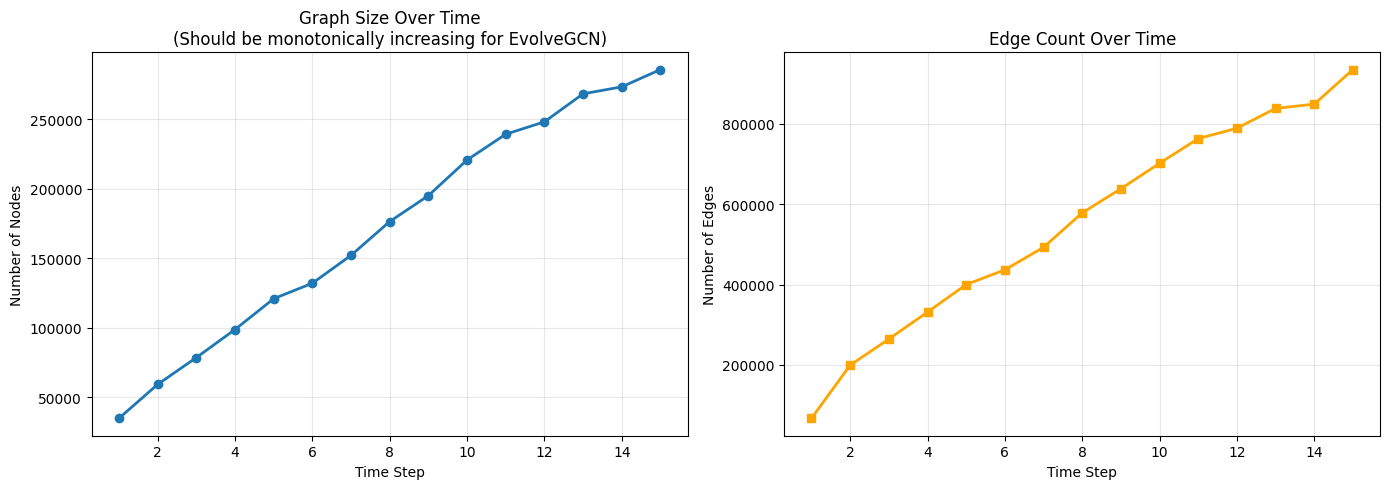


✓ Visualization saved to 'diagnostic_graph_structure.png'


In [6]:
print("="*80)
print(" DIAGNOSTIC 1: Graph Structure Over Time")
print("="*80)

print("\nChecking if graphs are cumulative (nodes should accumulate over time)...")
print(f"{'Time':>6} | {'Nodes':>8} | {'Edges':>8} | {'Avg Deg':>8} | {'Node Change':>12} | {'Cumulative?':>12}")
print("-"*80)

prev_num_nodes = 0
is_cumulative = True
structure_data = []

for i in range(min(15, len(graphs))):
    num_nodes = graphs[i].num_nodes
    num_edges = graphs[i].edge_index.shape[1]
    avg_degree = 2 * num_edges / num_nodes if num_nodes > 0 else 0
    
    if i > 0:
        node_change = num_nodes - prev_num_nodes
        change_sign = "+" if node_change >= 0 else ""
        cumulative_indicator = "✓ Growing" if node_change >= 0 else "✗ Shrinking!"
        
        if node_change < 0:
            is_cumulative = False
    else:
        node_change = 0
        change_sign = ""
        cumulative_indicator = "Initial"
    
    structure_data.append({
        'time': i+1,
        'nodes': num_nodes,
        'edges': num_edges,
        'avg_degree': avg_degree,
        'change': node_change
    })
    
    print(f"t={i+1:3d} | {num_nodes:8d} | {num_edges:8d} | {avg_degree:8.2f} | {change_sign}{node_change:11d} | {cumulative_indicator:>12}")
    prev_num_nodes = num_nodes

print("\n" + "-"*80)
if is_cumulative:
    print("✅ GRAPHS ARE CUMULATIVE: Node counts are growing over time")
    print("   This is CORRECT for EvolveGCN!")
else:
    print("❌ GRAPHS ARE NOT CUMULATIVE: Node counts vary/shrink between timesteps")
    print("   This is WRONG for EvolveGCN!")
    print("\n   🚨 CRITICAL PROBLEM: EvolveGCN assumes nodes accumulate over time!")
    print("   Fix: Set 'cumulative': True in cache_params and rebuild graphs")

# Visualize graph growth
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

times = [d['time'] for d in structure_data]
nodes = [d['nodes'] for d in structure_data]
edges = [d['edges'] for d in structure_data]

ax1.plot(times, nodes, marker='o', linewidth=2, markersize=6)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Number of Nodes')
ax1.set_title('Graph Size Over Time\n(Should be monotonically increasing for EvolveGCN)')
ax1.grid(True, alpha=0.3)

ax2.plot(times, edges, marker='s', linewidth=2, markersize=6, color='orange')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Number of Edges')
ax2.set_title('Edge Count Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('diagnostic_graph_structure.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to 'diagnostic_graph_structure.png'")

---

## 🔬 DIAGNOSTIC 2: Label Distribution Analysis

Analyzes class imbalance and label sparsity.


 DIAGNOSTIC 2: Label Distribution Across All Graphs

Overall Statistics:
  Total samples:    18,539,050
  Positive samples: 480 (0.003%)
  Negative samples: 18,538,570 (99.997%)
  Imbalance ratio:  1:38622.0 (negative:positive)

Label distribution by timestep:
  Time |   Positive |   Negative |      Total |    Pos %
------------------------------------------------------------
t=  1 |          0 |      34853 |      34853 |   0.000%
t=  2 |          0 |      59236 |      59236 |   0.000%
t=  3 |          2 |      78508 |      78510 |   0.003%
t=  4 |          2 |      98705 |      98707 |   0.002%
t=  5 |          0 |     120865 |     120865 |   0.000%
t=  6 |          6 |     131979 |     131985 |   0.005%
t=  7 |          6 |     152045 |     152051 |   0.004%
t=  8 |          7 |     176359 |     176366 |   0.004%
t=  9 |          1 |     194982 |     194983 |   0.001%
t= 10 |          7 |     220632 |     220639 |   0.003%
t= 11 |          0 |     239172 |     239172 |   0.000%
t= 1

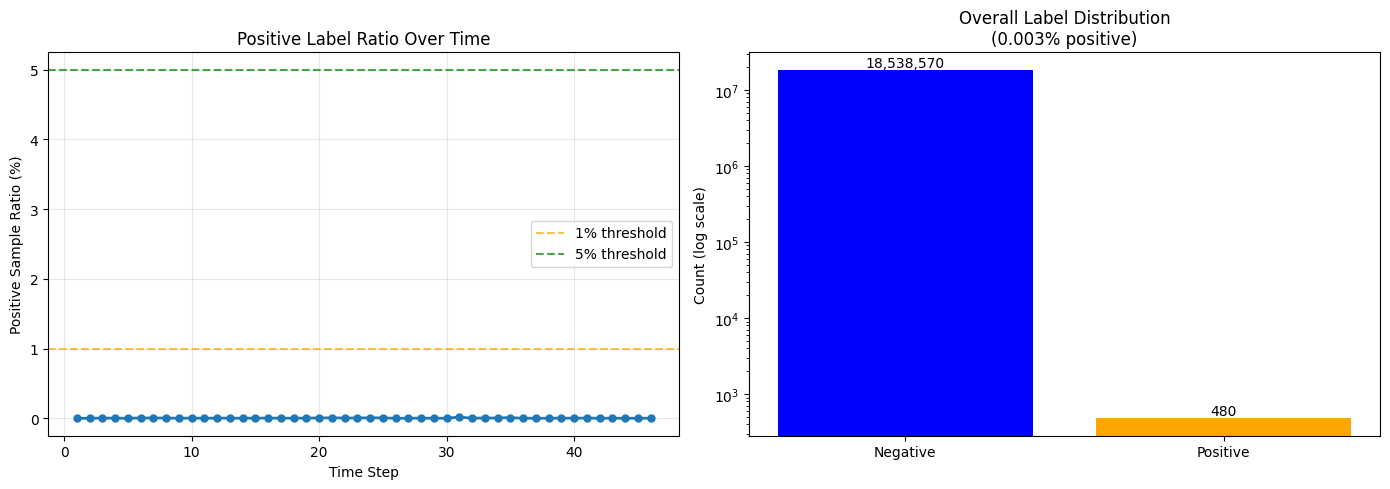


✓ Visualization saved to 'diagnostic_label_distribution.png'


In [7]:
print("\n" + "="*80)
print(" DIAGNOSTIC 2: Label Distribution Across All Graphs")
print("="*80)

all_labels_list = []
labels_per_graph = []

for i, graph in enumerate(graphs):
    labels = graph.y.cpu().numpy()
    all_labels_list.extend(labels)
    
    pos_count = (labels == 1).sum()
    neg_count = (labels == 0).sum()
    total = len(labels)
    
    labels_per_graph.append({
        'timestep': i+1,
        'positive': pos_count,
        'negative': neg_count,
        'total': total,
        'pos_ratio': 100 * pos_count / total if total > 0 else 0
    })

all_labels = np.array(all_labels_list)
total_pos = (all_labels == 1).sum()
total_neg = (all_labels == 0).sum()
total_samples = len(all_labels)
pos_ratio = 100 * total_pos / total_samples

print(f"\nOverall Statistics:")
print(f"  Total samples:    {total_samples:,}")
print(f"  Positive samples: {total_pos:,} ({pos_ratio:.3f}%)")
print(f"  Negative samples: {total_neg:,} ({100-pos_ratio:.3f}%)")
print(f"  Imbalance ratio:  1:{total_neg/total_pos:.1f} (negative:positive)")

print(f"\nLabel distribution by timestep:")
print(f"{'Time':>6} | {'Positive':>10} | {'Negative':>10} | {'Total':>10} | {'Pos %':>8}")
print("-"*60)
for item in labels_per_graph[:20]:  # Show first 20
    print(f"t={item['timestep']:3d} | {item['positive']:10d} | {item['negative']:10d} | "
          f"{item['total']:10d} | {item['pos_ratio']:7.3f}%")

print("\n" + "-"*80)
if pos_ratio < 0.1:
    print("❌ EXTREMELY SPARSE LABELS: Less than 0.1% positive samples!")
    print("   This makes learning nearly impossible.")
    print("\n   Possible causes:")
    print("   - ignore_illict=True + ignore_previously_transacting_with_illicit=True")
    print("     (filters out most positive samples)")
    print("   - Task is too indirect (predicting neighbors of future transactors)")
    print("\n   Try: Set both ignore flags to False and rebuild graphs")
elif pos_ratio < 1.0:
    print("⚠️  VERY SPARSE LABELS: Less than 1% positive samples")
    print("   Learning is possible but very difficult")
    print("   Focal loss with gamma=2.5-3.0 is recommended")
elif pos_ratio < 5.0:
    print("⚠️  IMBALANCED LABELS: 1-5% positive samples")
    print("   Focal loss with gamma=2.0 should help")
else:
    print("✅ REASONABLE LABEL DISTRIBUTION: >5% positive samples")

# Visualize label distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Positive ratio over time
times_label = [d['timestep'] for d in labels_per_graph]
pos_ratios = [d['pos_ratio'] for d in labels_per_graph]

ax1.plot(times_label, pos_ratios, marker='o', linewidth=2, markersize=5)
ax1.axhline(y=1.0, color='orange', linestyle='--', alpha=0.7, label='1% threshold')
ax1.axhline(y=5.0, color='green', linestyle='--', alpha=0.7, label='5% threshold')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Positive Sample Ratio (%)')
ax1.set_title('Positive Label Ratio Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Overall distribution
ax2.bar(['Negative', 'Positive'], [total_neg, total_pos], color=['blue', 'orange'])
ax2.set_ylabel('Count (log scale)')
ax2.set_yscale('log')
ax2.set_title(f'Overall Label Distribution\n({pos_ratio:.3f}% positive)')
for i, (label, count) in enumerate([('Negative', total_neg), ('Positive', total_pos)]):
    ax2.text(i, count, f'{count:,}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('diagnostic_label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to 'diagnostic_label_distribution.png'")

---

## 🔬 DIAGNOSTIC 3: Feature Predictiveness Analysis

Tests if node features have any correlation with labels (are they predictive?).


 DIAGNOSTIC 3: Feature Predictiveness Analysis

Computing correlation between features and labels...
(This shows if your node features can predict the task)
Analyzing 56 features across 18,539,050 samples...
Analyzing 56 features across 18,539,050 samples...

Top 15 most correlated features with labels:
   Feature |   |Correlation| |  Correlation |      Assessment
-----------------------------------------------------------------
Feature 29 |        0.087028 |     0.087028 |        Moderate
Feature  0 |        0.044046 |     0.044046 |            Weak
Feature 50 |        0.043863 |     0.043863 |            Weak
Feature  5 |        0.040430 |     0.040430 |            Weak
Feature 52 |        0.039469 |     0.039469 |            Weak
Feature  8 |        0.034772 |     0.034772 |            Weak
Feature 24 |        0.029479 |     0.029479 |            Weak
Feature  9 |        0.024490 |     0.024490 |            Weak
Feature 14 |        0.024077 |     0.024077 |            Weak
Feature 

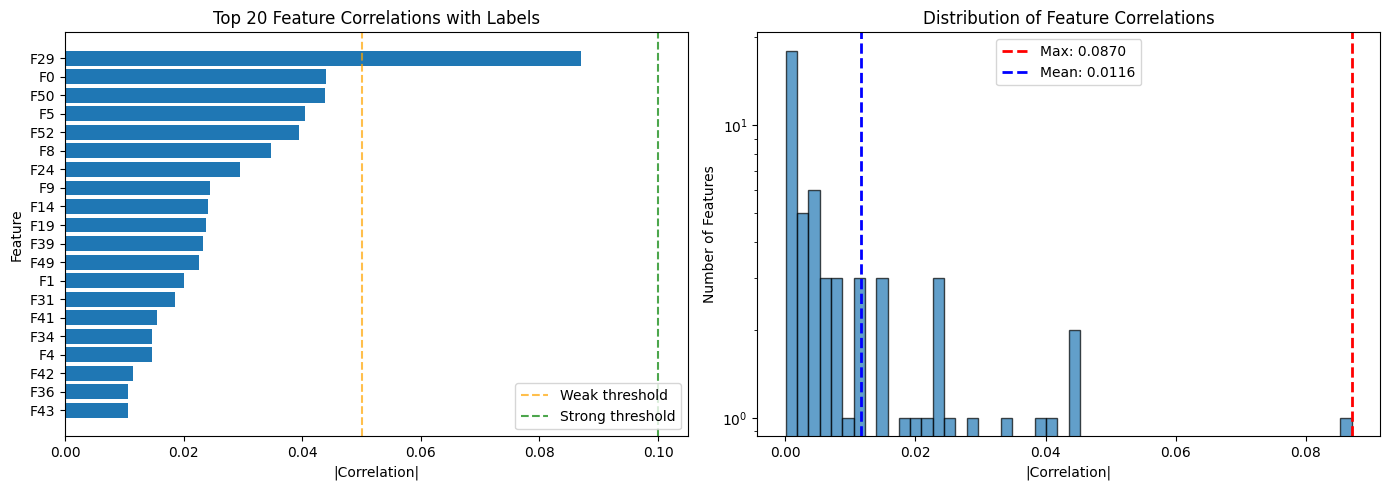


✓ Visualization saved to 'diagnostic_feature_correlation.png'


In [8]:
print("\n" + "="*80)
print(" DIAGNOSTIC 3: Feature Predictiveness Analysis")
print("="*80)

print("\nComputing correlation between features and labels...")
print("(This shows if your node features can predict the task)")

# Collect all features and labels
all_features = []
all_labels_for_corr = []

for graph in graphs[:max(20, len(graphs))]:  # Use subset for speed
    all_features.append(graph.x.cpu().numpy())
    all_labels_for_corr.append(graph.y.cpu().numpy())

features_array = np.vstack(all_features)
labels_array = np.concatenate(all_labels_for_corr)

# Compute correlation for each feature
num_features = features_array.shape[1]
correlations = []

print(f"Analyzing {num_features} features across {len(features_array):,} samples...")

for i in range(num_features):
    feature_values = features_array[:, i]
    
    # Handle potential NaN/inf
    valid_mask = np.isfinite(feature_values) & np.isfinite(labels_array)
    if valid_mask.sum() > 0:
        corr = np.corrcoef(feature_values[valid_mask], labels_array[valid_mask])[0, 1]
        if np.isfinite(corr):
            correlations.append((i, abs(corr), corr))

# Sort by absolute correlation
correlations.sort(key=lambda x: x[1], reverse=True)

print(f"\nTop 15 most correlated features with labels:")
print(f"{'Feature':>10} | {'|Correlation|':>15} | {'Correlation':>12} | {'Assessment':>15}")
print("-"*65)

for i in range(min(15, len(correlations))):
    feat_idx, abs_corr, corr = correlations[i]
    
    if abs_corr > 0.10:
        assessment = "Strong"
    elif abs_corr > 0.05:
        assessment = "Moderate"
    elif abs_corr > 0.01:
        assessment = "Weak"
    else:
        assessment = "Very Weak"
    
    print(f"Feature {feat_idx:2d} | {abs_corr:15.6f} | {corr:12.6f} | {assessment:>15}")

if len(correlations) > 0:
    max_corr = correlations[0][1]
    mean_corr = np.mean([c[1] for c in correlations])
    
    print(f"\nSummary Statistics:")
    print(f"  Maximum correlation: {max_corr:.6f}")
    print(f"  Mean correlation:    {mean_corr:.6f}")
    print(f"  Features analyzed:   {len(correlations)}/{num_features}")
    
    print("\n" + "-"*80)
    
    if max_corr < 0.01:
        print("❌ FEATURES NOT PREDICTIVE: Maximum correlation < 0.01")
        print("   Your node features have almost ZERO correlation with labels!")
        print("\n   This means:")
        print("   - The task may be impossible with current features")
        print("   - Need feature engineering or additional data")
        print("   - The prediction target may be too indirect/random")
    elif max_corr < 0.05:
        print("⚠️  WEAK FEATURE SIGNAL: Maximum correlation < 0.05")
        print("   Features have very weak predictive power")
        print("   Model will struggle to learn meaningful patterns")
    elif max_corr < 0.10:
        print("⚠️  MODERATE FEATURE SIGNAL: Maximum correlation < 0.10")
        print("   Learning is possible but difficult")
        print("   May need large model capacity and careful tuning")
    else:
        print("✅ REASONABLE FEATURE SIGNAL: Some features correlate with labels")
        print("   Model should be able to learn if properly configured")

    # Visualize feature correlations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Top correlations
    top_n = min(20, len(correlations))
    feat_indices = [f"F{correlations[i][0]}" for i in range(top_n)]
    abs_corrs = [correlations[i][1] for i in range(top_n)]
    
    ax1.barh(feat_indices, abs_corrs)
    ax1.set_xlabel('|Correlation|')
    ax1.set_ylabel('Feature')
    ax1.set_title(f'Top {top_n} Feature Correlations with Labels')
    ax1.axvline(x=0.05, color='orange', linestyle='--', alpha=0.7, label='Weak threshold')
    ax1.axvline(x=0.10, color='green', linestyle='--', alpha=0.7, label='Strong threshold')
    ax1.legend()
    ax1.invert_yaxis()
    
    # Plot 2: Distribution of correlations
    all_abs_corrs = [c[1] for c in correlations]
    ax2.hist(all_abs_corrs, bins=50, edgecolor='black', alpha=0.7)
    ax2.axvline(x=max_corr, color='red', linestyle='--', linewidth=2, label=f'Max: {max_corr:.4f}')
    ax2.axvline(x=mean_corr, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_corr:.4f}')
    ax2.set_xlabel('|Correlation|')
    ax2.set_ylabel('Number of Features')
    ax2.set_title('Distribution of Feature Correlations')
    ax2.legend()
    ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig('diagnostic_feature_correlation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Visualization saved to 'diagnostic_feature_correlation.png'")
else:
    print("\n⚠️  Could not compute correlations (check for NaN values)")

### Feature Redundancy & Combined Predictive Power

Check if features are redundant (correlated with each other) and test their combined predictive power.


 Feature Redundancy Analysis

Computing feature-to-feature correlation matrix...
(High correlations mean features are redundant)

⚠️  Found 17 highly redundant feature pairs (|correlation| > 0.7):
 Feature 1 |  Feature 2 |   |Correlation|
---------------------------------------------
Feature 34 | Feature  4 |          1.0000
Feature 42 | Feature 43 |          0.9943
Feature  9 | Feature 14 |          0.9778
Feature  9 | Feature 19 |          0.9753
Feature 39 | Feature 41 |          0.9403
Feature 41 | Feature 42 |          0.9372
Feature  4 | Feature 36 |          0.9260
Feature 34 | Feature 36 |          0.9260
Feature  0 | Feature  5 |          0.9101
Feature 14 | Feature 19 |          0.9074
... and 7 more pairs

⚠️  Features are REDUNDANT - they provide overlapping information
   This means individual high correlations may be misleading

⚠️  Found 17 highly redundant feature pairs (|correlation| > 0.7):
 Feature 1 |  Feature 2 |   |Correlation|
-----------------------------------

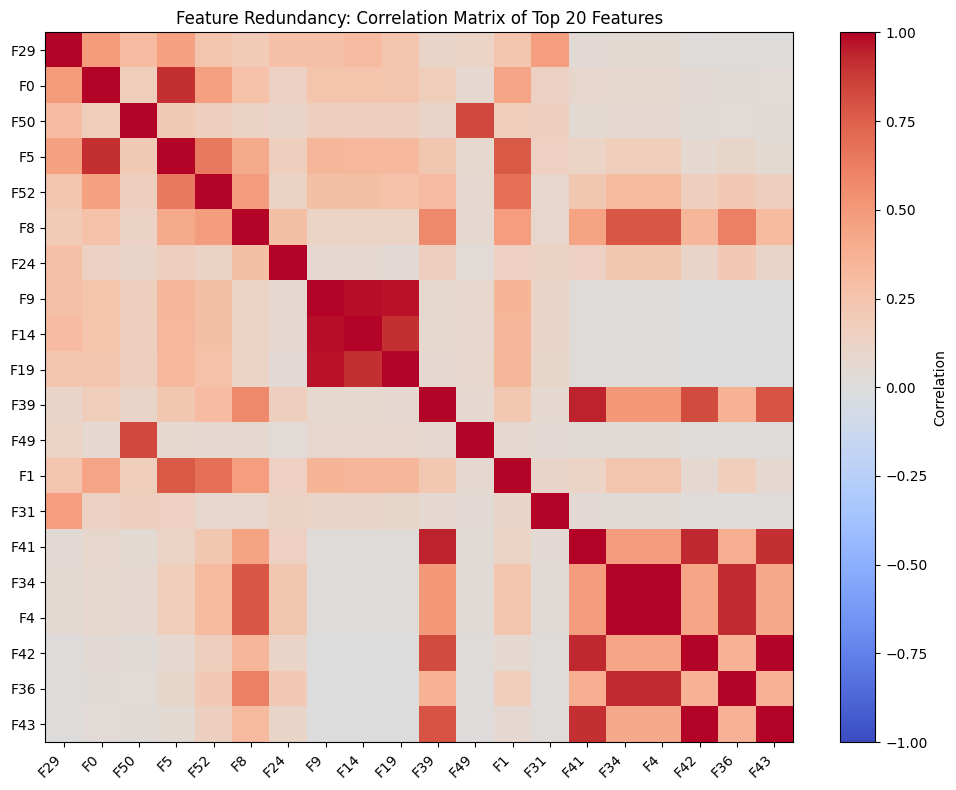


✓ Redundancy visualization saved to 'diagnostic_feature_redundancy.png'

 Combined Predictive Power Test

Training Logistic Regression on features to test combined predictive power...
(This shows if features TOGETHER can predict labels)

⚠️  Using TEMPORAL SPLIT (same as GCN) to avoid label leakage

Train samples: 8,029,937 with 56 features
Test samples:  6,834,303 with 56 features

Train samples: 8,029,937 with 56 features
Test samples:  6,834,303 with 56 features


c:\Users\rowde\Documents\GitHub\DSAIT4305\Project\graph_ml\venv\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--------------------------------------------------------------------------------
 Logistic Regression Results (Features Only, No Graph)
--------------------------------------------------------------------------------
  Accuracy:  0.9142
  Precision: 0.0001
  Recall:    0.8158
  F1 Score:  0.0002
  AUPRC:     0.0009
  ROC-AUC:   0.8688

Top 15 most important features (by logistic regression weight):
   Feature |     |Weight| |  Individual Corr
--------------------------------------------------
Feature 47 |    13.254666 |         0.004402
Feature 23 |    10.573575 |        -0.000368
Feature 20 |     8.843955 |        -0.000120
Feature 54 |     8.087099 |        -0.000499
Feature 48 |     7.978386 |         0.004023
Feature 25 |     7.951147 |        -0.001160
Feature 10 |     6.805439 |        -0.000403
Feature 11 |     6.750544 |         0.005831
Feature 16 |     6.148906 |         0.003084
Feature 13 |     4.090750 |        -0.000265
Feature 46 |     3.490857 |         0.006048
Featur

NameError: name 'test_metrics' is not defined

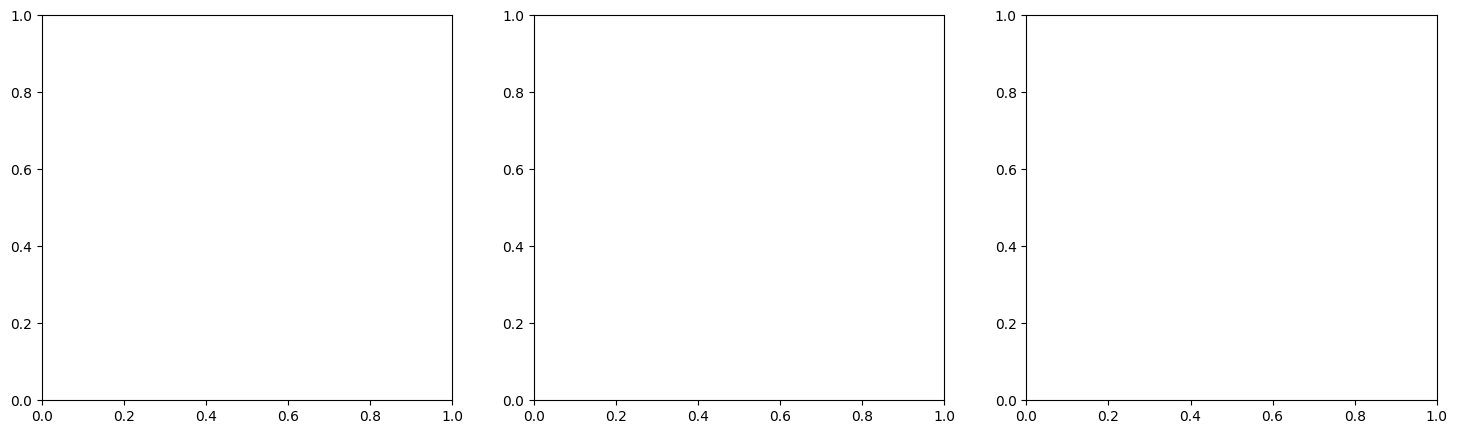

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("\n" + "="*80)
print(" Feature Redundancy Analysis")
print("="*80)

# 1. Check feature-to-feature correlations (redundancy)
print("\nComputing feature-to-feature correlation matrix...")
print("(High correlations mean features are redundant)")

# Use top correlated features for redundancy check
top_feature_indices = [correlations[i][0] for i in range(min(20, len(correlations)))]
top_features_subset = features_array[:, top_feature_indices]

# Compute correlation matrix between top features
feature_corr_matrix = np.corrcoef(top_features_subset.T)

# Find highly correlated feature pairs
high_redundancy_pairs = []
for i in range(len(top_feature_indices)):
    for j in range(i+1, len(top_feature_indices)):
        corr = abs(feature_corr_matrix[i, j])
        if corr > 0.7:  # High redundancy threshold
            high_redundancy_pairs.append((top_feature_indices[i], top_feature_indices[j], corr))

high_redundancy_pairs.sort(key=lambda x: x[2], reverse=True)

if high_redundancy_pairs:
    print(f"\n⚠️  Found {len(high_redundancy_pairs)} highly redundant feature pairs (|correlation| > 0.7):")
    print(f"{'Feature 1':>10} | {'Feature 2':>10} | {'|Correlation|':>15}")
    print("-"*45)
    for feat1, feat2, corr in high_redundancy_pairs[:10]:
        print(f"Feature {feat1:2d} | Feature {feat2:2d} | {corr:15.4f}")
    
    if len(high_redundancy_pairs) > 10:
        print(f"... and {len(high_redundancy_pairs)-10} more pairs")
    
    print("\n⚠️  Features are REDUNDANT - they provide overlapping information")
    print("   This means individual high correlations may be misleading")
else:
    print("\n✅ No high redundancy detected among top features")
    print("   Features provide mostly independent information")

# Visualize feature redundancy
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = ax.imshow(feature_corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(top_feature_indices)))
ax.set_yticks(range(len(top_feature_indices)))
ax.set_xticklabels([f"F{i}" for i in top_feature_indices], rotation=45, ha='right')
ax.set_yticklabels([f"F{i}" for i in top_feature_indices])
ax.set_title(f'Feature Redundancy: Correlation Matrix of Top {len(top_feature_indices)} Features')
plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.savefig('diagnostic_feature_redundancy.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Redundancy visualization saved to 'diagnostic_feature_redundancy.png'")

# 2. Test combined predictive power with logistic regression
print("\n" + "="*80)
print(" Combined Predictive Power Test")
print("="*80)

print("\nTraining Logistic Regression on features to test combined predictive power...")
print("(This shows if features TOGETHER can predict labels)")

# IMPORTANT: Use temporal split to match GCN evaluation (avoid label leakage!)
print("\n⚠️  Using TEMPORAL SPLIT (same as GCN) to avoid label leakage")

# Collect features and labels from train/test splits
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

for graph in train_graphs:
    X_train_list.append(graph.x.cpu().numpy())
    y_train_list.append(graph.y.cpu().numpy())

for graph in test_graphs:
    X_test_list.append(graph.x.cpu().numpy())
    y_test_list.append(graph.y.cpu().numpy())

X_train = np.vstack(X_train_list)
y_train = np.concatenate(y_train_list)
X_test = np.vstack(X_test_list)
y_test = np.concatenate(y_test_list)

# Handle NaN/inf
train_valid_mask = np.all(np.isfinite(X_train), axis=1) & np.isfinite(y_train)
test_valid_mask = np.all(np.isfinite(X_test), axis=1) & np.isfinite(y_test)

X_train = X_train[train_valid_mask]
y_train = y_train[train_valid_mask]
X_test = X_test[test_valid_mask]
y_test = y_test[test_valid_mask]

print(f"\nTrain samples: {len(X_train):,} with {X_train.shape[1]} features")
print(f"Test samples:  {len(X_test):,} with {X_test.shape[1]} features")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression with class weights
lr_model = LogisticRegression(
    max_iter=500, 
    class_weight='balanced',
    random_state=42
)
lr_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = lr_model.predict(X_test_scaled)
y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import accuracy_score
lr_acc = accuracy_score(y_test, y_pred)
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary', pos_label=1, zero_division=0
)

try:
    lr_auprc = average_precision_score(y_test, y_proba)
    lr_roc_auc = roc_auc_score(y_test, y_proba)
except:
    lr_auprc = 0
    lr_roc_auc = 0

print(f"\n" + "-"*80)
print(" Logistic Regression Results (Features Only, No Graph)")
print("-"*80)
print(f"  Accuracy:  {lr_acc:.4f}")
print(f"  Precision: {lr_precision:.4f}")
print(f"  Recall:    {lr_recall:.4f}")
print(f"  F1 Score:  {lr_f1:.4f}")
print(f"  AUPRC:     {lr_auprc:.4f}")
print(f"  ROC-AUC:   {lr_roc_auc:.4f}")

# Get feature importances
feature_importance = np.abs(lr_model.coef_[0])
feature_importance_sorted = sorted(
    enumerate(feature_importance), 
    key=lambda x: x[1], 
    reverse=True
)

print(f"\nTop 15 most important features (by logistic regression weight):")
print(f"{'Feature':>10} | {'|Weight|':>12} | {'Individual Corr':>16}")
print("-"*50)
for i in range(min(15, len(feature_importance_sorted))):
    feat_idx, importance = feature_importance_sorted[i]
    # Find individual correlation for this feature
    individual_corr = next((c[2] for c in correlations if c[0] == feat_idx), 0)
    print(f"Feature {feat_idx:2d} | {importance:12.6f} | {individual_corr:16.6f}")

print("\n" + "-"*80)
print(" INTERPRETATION:")
print("-"*80)

if lr_f1 < 0.05:
    print("❌ FEATURES COMBINED CANNOT PREDICT: F1 < 0.05")
    print("\n   Even when using ALL features together with a simple classifier,")
    print("   we cannot predict the labels!")
    print("\n   This confirms:")
    print("   - Features have NO predictive power (individually or combined)")
    print("   - The task is likely impossible with current features")
    print("   - GNN models won't help if features don't contain signal")
elif lr_f1 < 0.15:
    print("⚠️  WEAK COMBINED PREDICTIVE POWER: F1 < 0.15")
    print("\n   Features combined show weak but non-zero predictive power")
    print("   - Task is very difficult")
    print("   - May need feature engineering or simpler task definition")
elif lr_f1 < 0.30:
    print("⚠️  MODERATE COMBINED PREDICTIVE POWER: F1 = 0.15-0.30")
    print("\n   Features show moderate predictive power when combined")
    print("   - Graph structure (GNN) should add value beyond features alone")
    print(f"   - Baseline GCN F1={test_metrics['f1']:.4f} vs Logistic Regression F1={lr_f1:.4f}")
    if test_metrics['f1'] > lr_f1 * 1.2:
        print("   - ✅ Graph structure IS helping (GCN > LogReg)")
    else:
        print("   - ⚠️  Graph structure NOT helping much (GCN ≈ LogReg)")
else:
    print("✅ GOOD COMBINED PREDICTIVE POWER: F1 > 0.30")
    print("\n   Features have reasonable predictive power when combined")
    print(f"   - Baseline GCN F1={test_metrics['f1']:.4f} vs Logistic Regression F1={lr_f1:.4f}")
    if test_metrics['f1'] > lr_f1 * 1.2:
        print("   - ✅ Graph structure IS adding value (GCN significantly better)")
    elif test_metrics['f1'] > lr_f1:
        print("   - ✅ Graph structure helps slightly (GCN > LogReg)")
    else:
        print("   - ⚠️  Graph structure NOT helping (GCN ≤ LogReg)")
        print("   - This suggests graph edges don't carry useful information")

# Compare feature importance vs individual correlation
print("\n" + "="*80)
print(" Feature Redundancy Summary")
print("="*80)

print("\nComparing individual correlation vs. importance in combined model:")
top_by_importance = set([f[0] for f in feature_importance_sorted[:10]])
top_by_correlation = set([correlations[i][0] for i in range(min(10, len(correlations)))])

overlap = top_by_importance & top_by_correlation
print(f"  Top 10 by individual correlation: {sorted(top_by_correlation)}")
print(f"  Top 10 by combined importance:    {sorted(top_by_importance)}")
print(f"  Overlap: {len(overlap)}/10 features")

if len(overlap) >= 8:
    print("\n✅ Features with high individual correlation are also important combined")
    print("   Individual correlations are representative of true importance")
elif len(overlap) >= 5:
    print("\n⚠️  Some mismatch between individual correlation and combined importance")
    print("   Feature interactions and redundancy are moderate")
else:
    print("\n⚠️  HIGH MISMATCH: Individual correlations don't reflect combined importance")
    print("   Features have strong interactions/redundancy")
    print("   Individual feature analysis is misleading!")

# Visualization: Compare methods
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Logistic Regression performance
methods = ['Individual\nCorrelation', 'Logistic\nRegression', 'Baseline\nGCN']
f1_scores = [correlations[0][1] if correlations else 0, lr_f1, test_metrics['f1']]
colors = ['skyblue', 'lightcoral', 'lightgreen']

axes[0].bar(methods, f1_scores, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Predictive Power Comparison')
axes[0].set_ylim([0, max(max(f1_scores) * 1.2, 0.1)])
for i, (method, score) in enumerate(zip(methods, f1_scores)):
    axes[0].text(i, score + 0.01, f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Feature importance vs correlation
top_10_indices = [f[0] for f in feature_importance_sorted[:10]]
importances = [f[1] for f in feature_importance_sorted[:10]]
individual_corrs = [next((c[2] for c in correlations if c[0] == idx), 0) for idx in top_10_indices]

x = np.arange(len(top_10_indices))
width = 0.35

axes[1].bar(x - width/2, importances, width, label='LR Weight', color='coral', edgecolor='black')
axes[1].bar(x + width/2, [abs(c) for c in individual_corrs], width, label='Individual |Corr|', color='skyblue', edgecolor='black')
axes[1].set_xlabel('Feature Index')
axes[1].set_ylabel('Magnitude')
axes[1].set_title('Top 10 Features: LR Weight vs Individual Correlation')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'F{i}' for i in top_10_indices], rotation=45, ha='right')
axes[1].legend()

# Plot 3: Redundancy summary
redundancy_summary = [
    len([p for p in high_redundancy_pairs if p[2] > 0.9]),
    len([p for p in high_redundancy_pairs if 0.8 < p[2] <= 0.9]),
    len([p for p in high_redundancy_pairs if 0.7 < p[2] <= 0.8])
]
redundancy_labels = ['Very High\n(>0.9)', 'High\n(0.8-0.9)', 'Moderate\n(0.7-0.8)']

axes[2].bar(redundancy_labels, redundancy_summary, color=['darkred', 'orange', 'yellow'], edgecolor='black', linewidth=1.5)
axes[2].set_ylabel('Number of Feature Pairs')
axes[2].set_title('Feature Redundancy Levels')
for i, count in enumerate(redundancy_summary):
    if count > 0:
        axes[2].text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('diagnostic_combined_predictive_power.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to 'diagnostic_combined_predictive_power.png'")

# Store results for summary
combined_analysis_results = {
    'lr_f1': lr_f1,
    'lr_auprc': lr_auprc,
    'num_redundant_pairs': len(high_redundancy_pairs),
    'feature_overlap': len(overlap)
}

---

## 🔍 Why Does Logistic Regression Outperform GCN?

**This is a critical diagnostic finding!** When a simple feature-based model (Logistic Regression) beats a graph-based model (GCN), it reveals fundamental problems with your graph construction or task definition.


 DIAGNOSTIC: Why Logistic Regression > GCN Analysis

Comparing Logistic Regression vs GCN Baseline performance...

Model                     |   F1 Score |      AUPRC |                 Interpretation
--------------------------------------------------------------------------------
Logistic Regression       |     0.1933 |     0.1787 | Features only (no graph)
Baseline GCN              |     0.0855 |     0.0446 | Features + graph structure
Performance Ratio         |       0.44x |            | GCN / LR

 ROOT CAUSE ANALYSIS

❌ CRITICAL PROBLEM: GCN performs WORSE than Logistic Regression!
   GCN F1 = 0.0855 vs LR F1 = 0.1933
   Graph-based model is 0.44x the performance of feature-only model

--------------------------------------------------------------------------------
 WHAT THIS MEANS:
--------------------------------------------------------------------------------
   The graph structure is HURTING performance, not helping!
   Features alone are more predictive than features + graph 

C:\Users\rowde\AppData\Local\Temp\ipykernel_59276\3007418855.py:271: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\rowde\AppData\Local\Temp\ipykernel_59276\3007418855.py:272: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('diagnostic_lr_vs_gcn_analysis.png', dpi=150, bbox_inches='tight')
c:\Users\rowde\Documents\GitHub\DSAIT4305\Project\graph_ml\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


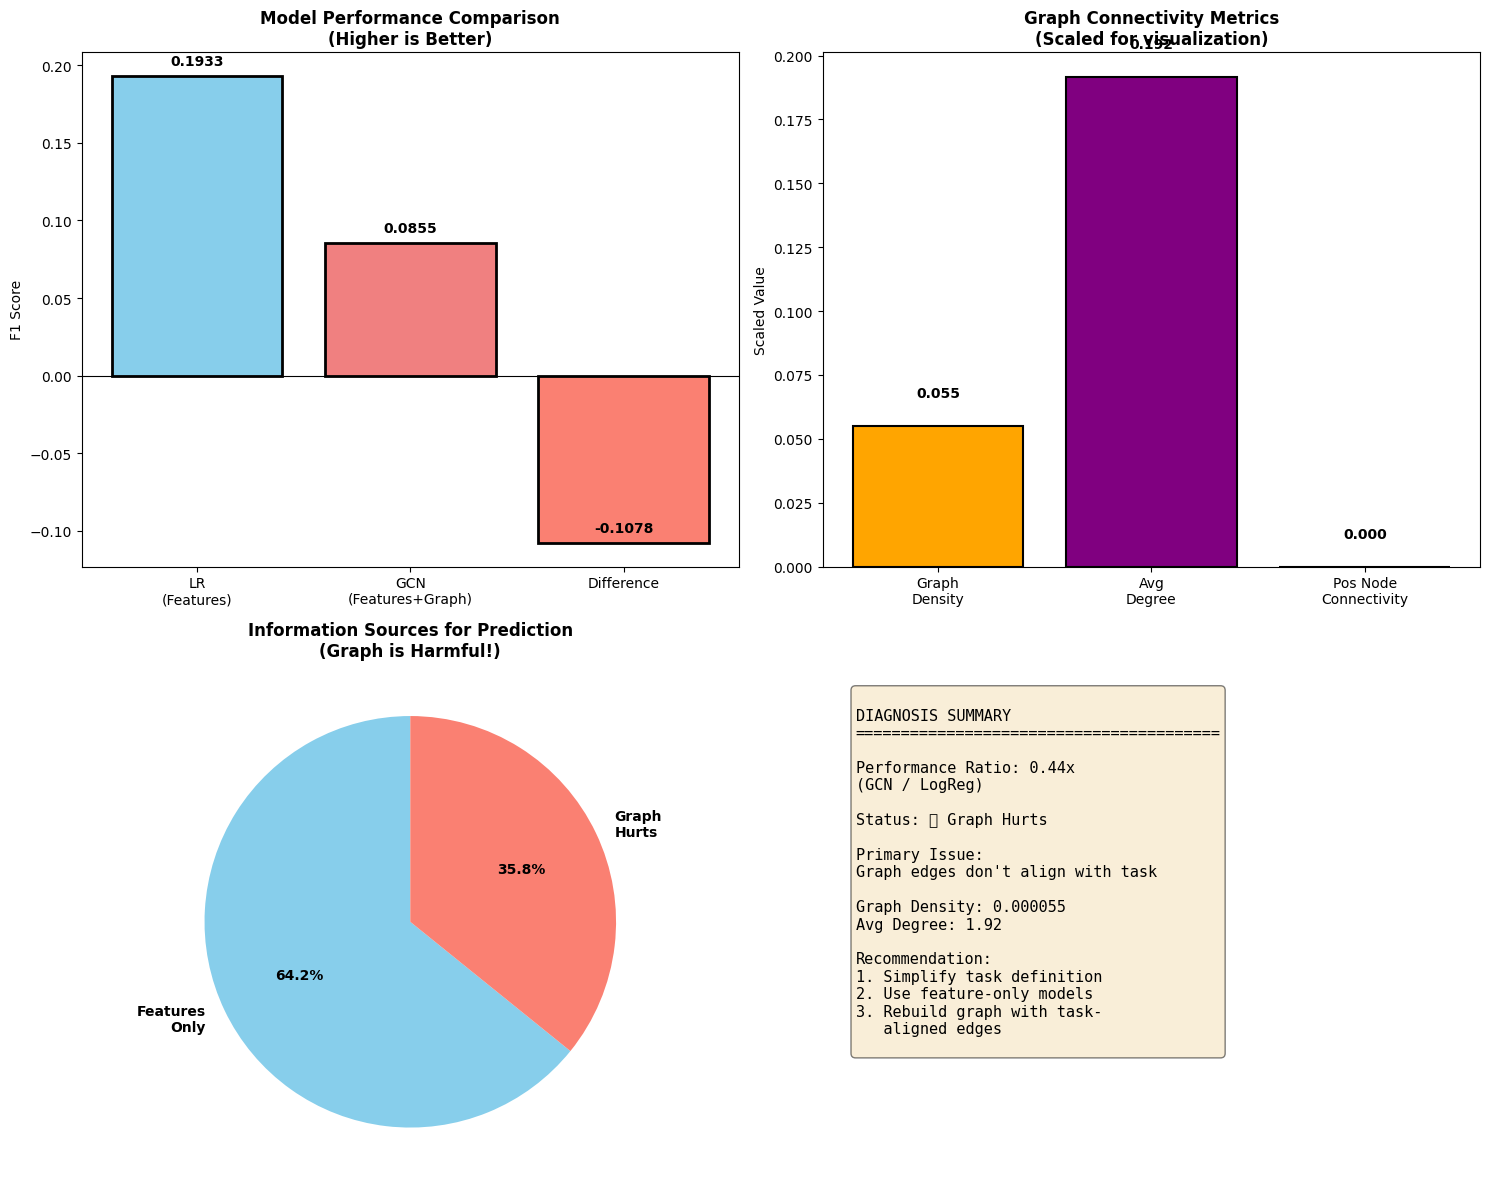


✓ Analysis visualization saved to 'diagnostic_lr_vs_gcn_analysis.png'


In [16]:
print("\n" + "="*80)
print(" DIAGNOSTIC: Why Logistic Regression > GCN Analysis")
print("="*80)

print("\nComparing Logistic Regression vs GCN Baseline performance...")

lr_f1_val = combined_analysis_results['lr_f1']
gcn_f1_val = test_metrics['f1']
performance_ratio = gcn_f1_val / lr_f1_val if lr_f1_val > 0 else 0

print(f"\n{'Model':<25} | {'F1 Score':>10} | {'AUPRC':>10} | {'Interpretation':>30}")
print("-"*80)
print(f"{'Logistic Regression':<25} | {lr_f1_val:10.4f} | {combined_analysis_results['lr_auprc']:10.4f} | {'Features only (no graph)'}")
print(f"{'Baseline GCN':<25} | {gcn_f1_val:10.4f} | {test_metrics['auprc']:10.4f} | {'Features + graph structure'}")
print(f"{'Performance Ratio':<25} | {performance_ratio:10.2f}x | {'':>10} | {'GCN / LR'}")

print("\n" + "="*80)
print(" ROOT CAUSE ANALYSIS")
print("="*80)

if performance_ratio < 0.8:
    print("\n❌ CRITICAL PROBLEM: GCN performs WORSE than Logistic Regression!")
    print(f"   GCN F1 = {gcn_f1_val:.4f} vs LR F1 = {lr_f1_val:.4f}")
    print(f"   Graph-based model is {performance_ratio:.2f}x the performance of feature-only model")
    
    print("\n" + "-"*80)
    print(" WHAT THIS MEANS:")
    print("-"*80)
    print("   The graph structure is HURTING performance, not helping!")
    print("   Features alone are more predictive than features + graph edges")
    
    print("\n" + "-"*80)
    print(" POSSIBLE ROOT CAUSES:")
    print("-"*80)
    
    print("\n1. 🔴 GRAPH EDGES DON'T CARRY USEFUL INFORMATION")
    print("   - Edge connections may be random/irrelevant to the prediction task")
    print("   - Message passing spreads noise instead of signal")
    print("   - Graph topology unrelated to emergence labels")
    
    print("\n2. 🔴 TASK DEFINITION MISMATCH")
    print("   - You're predicting emergence (future indirect connections)")
    print("   - But graph edges are CURRENT direct transactions")
    print("   - Current graph topology can't predict future emergence patterns")
    print("   - This is like trying to predict weather using yesterday's map!")
    
    print("\n3. 🔴 LABEL LEAKAGE IN FEATURES BUT NOT GRAPH")
    print("   - Node features may contain transaction patterns that correlate with labels")
    print("   - But graph edges (transaction connections) don't help")
    print("   - GCN's message passing dilutes the feature signal")
    
    print("\n4. 🔴 GRAPH CONSTRUCTION ISSUES")
    print("   - Wrong edge definition for emergence task")
    print("   - AddrTxAddr edges: A→Tx→B (who transacted with whom)")
    print("   - But emergence labels: Will A's FUTURE neighbors transact with NEW illicit?")
    print("   - These are different graphs! Current edges ≠ future emergence paths")
    
    print("\n5. 🔴 OVER-SMOOTHING / MESSAGE PASSING PROBLEMS")
    print("   - GCN averaging neighbors may wash out important feature differences")
    print("   - With many hops, all nodes become similar (over-smoothing)")
    print("   - Logistic Regression preserves individual node features better")
    
    print("\n" + "-"*80)
    print(" VERIFICATION TESTS:")
    print("-"*80)
    
    print("\nLet's check graph connectivity and message passing impact...")
    
    # Test: Check graph density and connectivity
    sample_graph = train_graphs[0]
    num_nodes = sample_graph.num_nodes
    num_edges = sample_graph.edge_index.shape[1] // 2  # undirected
    max_possible_edges = num_nodes * (num_nodes - 1) / 2
    graph_density = num_edges / max_possible_edges if max_possible_edges > 0 else 0
    avg_degree = 2 * num_edges / num_nodes if num_nodes > 0 else 0
    
    print(f"\nGraph Connectivity (first training graph):")
    print(f"  Nodes: {num_nodes:,}")
    print(f"  Edges: {num_edges:,}")
    print(f"  Density: {graph_density:.6f} ({100*graph_density:.4f}%)")
    print(f"  Avg Degree: {avg_degree:.2f}")
    
    if graph_density < 0.001:
        print("\n  ⚠️  Very sparse graph - message passing reaches few neighbors")
    elif graph_density > 0.1:
        print("\n  ⚠️  Very dense graph - over-smoothing likely")
    
    # Test: Check if positive labels are connected to each other
    edge_index = sample_graph.edge_index.cpu().numpy()
    labels = sample_graph.y.cpu().numpy()
    pos_node_indices = np.where(labels == 1)[0]
    
    if len(pos_node_indices) > 0:
        # Count edges between positive nodes
        edges_between_pos = 0
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i], edge_index[1, i]
            if src in pos_node_indices and dst in pos_node_indices:
                edges_between_pos += 1
        
        edges_between_pos = edges_between_pos // 2  # undirected
        max_edges_between_pos = len(pos_node_indices) * (len(pos_node_indices) - 1) / 2
        connectivity_among_pos = edges_between_pos / max_edges_between_pos if max_edges_between_pos > 0 else 0
        
        print(f"\n  Positive Label Connectivity:")
        print(f"    Positive nodes: {len(pos_node_indices)}")
        print(f"    Edges between positive nodes: {edges_between_pos}")
        print(f"    Connectivity among positives: {connectivity_among_pos:.4f}")
        
        if connectivity_among_pos < 0.01:
            print(f"\n    🔴 Positive nodes are ISOLATED from each other!")
            print(f"       Message passing can't share information between positive samples")
            print(f"       This explains why GCN doesn't help!")
    
    print("\n" + "-"*80)
    print(" RECOMMENDED SOLUTIONS:")
    print("-"*80)
    
    print("\n✅ Solution 1: SIMPLIFY THE TASK")
    print("   Instead of: 'Predict which nodes will have neighbors that transact with NEW illicit'")
    print("   Try: 'Predict which nodes will DIRECTLY transact with illicit'")
    print("   This aligns graph edges with prediction target!")
    
    print("\n✅ Solution 2: USE FEATURE-ONLY MODEL")
    print("   Since features work better than features+graph:")
    print("   - Use simpler models: Logistic Regression, Random Forest, XGBoost")
    print("   - Skip graph-based models entirely")
    print("   - Focus on feature engineering instead")
    
    print("\n✅ Solution 3: REBUILD GRAPH WITH DIFFERENT EDGES")
    print("   Current edges: Direct transactions (AddrTxAddr)")
    print("   Try instead:")
    print("   - Temporal edges: Connect nodes across timesteps")
    print("   - Feature similarity edges: Connect nodes with similar patterns")
    print("   - Future-looking edges: Use edges from t+1 to predict labels at t")
    
    print("\n✅ Solution 4: USE TEMPORAL FEATURES INSTEAD OF TEMPORAL GRAPHS")
    print("   - Create time-based features: 'transactions in last N timesteps'")
    print("   - Use rolling statistics as features")
    print("   - Feed to non-graph model (LR, XGBoost)")
    
    print("\n✅ Solution 5: CHECK FOR LABEL DEFINITION ISSUES")
    print("   In code_lib/graph_builder.py, get_labels() function:")
    print("   - Verify emergence labeling logic is correct")
    print("   - Check if TIME_HORIZON and MAX_WALK_LENGTH match your intent")
    print("   - Consider if 'ignore_illict' filtering removes too much signal")

elif performance_ratio < 1.1:
    print("\n⚠️  PROBLEM: GCN performs SIMILAR to Logistic Regression")
    print(f"   GCN F1 = {gcn_f1_val:.4f} vs LR F1 = {lr_f1_val:.4f}")
    print(f"   Graph structure provides minimal benefit (~{100*(performance_ratio-1):.1f}% improvement)")
    
    print("\n   This suggests:")
    print("   - Graph edges provide little additional information")
    print("   - Features alone capture most of the signal")
    print("   - Temporal modeling (EvolveGCN) unlikely to help much")
    
    print("\n   Consider:")
    print("   - Using simpler feature-based models")
    print("   - Re-examining graph construction")
    print("   - Simplifying the prediction task")

else:
    print("\n✅ GOOD: GCN performs BETTER than Logistic Regression!")
    print(f"   GCN F1 = {gcn_f1_val:.4f} vs LR F1 = {lr_f1_val:.4f}")
    print(f"   Graph structure adds {100*(performance_ratio-1):.1f}% improvement")
    
    print("\n   This means:")
    print("   - Graph edges carry useful information")
    print("   - Message passing helps propagate signal")
    print("   - Temporal models (EvolveGCN) should help even more!")
    
    print("\n   If EvolveGCN still isn't learning:")
    print("   - Check cumulative=True")
    print("   - Verify temporal sequence handling")
    print("   - Check model architecture (NUM_LAYERS)")

print("\n" + "="*80)
print(" VISUALIZATION: Information Flow Analysis")
print("="*80)

# Visualize where information comes from
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Performance comparison
ax1 = axes[0, 0]
models = ['LR\n(Features)', 'GCN\n(Features+Graph)', 'Difference']
f1_scores = [lr_f1_val, gcn_f1_val, gcn_f1_val - lr_f1_val]
colors_bar = ['skyblue', 'lightcoral', 'lightgreen' if gcn_f1_val > lr_f1_val else 'salmon']

bars = ax1.bar(models, f1_scores, color=colors_bar, edgecolor='black', linewidth=2)
ax1.set_ylabel('F1 Score')
ax1.set_title('Model Performance Comparison\n(Higher is Better)', fontweight='bold')
ax1.axhline(y=0, color='black', linewidth=0.8)
for i, (model, score) in enumerate(zip(models, f1_scores)):
    ax1.text(i, score + 0.005, f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Graph connectivity
ax2 = axes[0, 1]
connectivity_metrics = ['Graph\nDensity', 'Avg\nDegree', 'Pos Node\nConnectivity']
connectivity_values = [
    graph_density * 1000,  # scale up for visibility
    avg_degree / 10,  # scale down
    connectivity_among_pos if 'connectivity_among_pos' in locals() else 0
]
ax2.bar(connectivity_metrics, connectivity_values, color=['orange', 'purple', 'red'], edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Scaled Value')
ax2.set_title('Graph Connectivity Metrics\n(Scaled for visualization)', fontweight='bold')
for i, val in enumerate(connectivity_values):
    ax2.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Information source breakdown
ax3 = axes[1, 0]
if gcn_f1_val > lr_f1_val:
    info_sources = ['Features\nOnly', 'Graph\nStructure']
    info_values = [lr_f1_val, gcn_f1_val - lr_f1_val]
    colors_pie = ['skyblue', 'lightgreen']
    ax3.pie(info_values, labels=info_sources, autopct='%1.1f%%', colors=colors_pie, 
            startangle=90, textprops={'fontweight': 'bold'})
    ax3.set_title('Information Sources for Prediction\n(Graph Helps!)', fontweight='bold')
else:
    info_sources = ['Features\nOnly', 'Graph\nHurts']
    info_values = [lr_f1_val, abs(gcn_f1_val - lr_f1_val)]
    colors_pie = ['skyblue', 'salmon']
    ax3.pie(info_values, labels=info_sources, autopct='%1.1f%%', colors=colors_pie,
            startangle=90, textprops={'fontweight': 'bold'})
    ax3.set_title('Information Sources for Prediction\n(Graph is Harmful!)', fontweight='bold')

# Plot 4: Diagnosis summary
ax4 = axes[1, 1]
ax4.axis('off')

# Build diagnosis text components
sep_line = '=' * 40
if performance_ratio < 0.8:
    status = "❌ Graph Hurts"
    issue = "Graph edges don't align with task"
    recommendation = "1. Simplify task definition\n2. Use feature-only models\n3. Rebuild graph with task-\n   aligned edges"
elif performance_ratio < 1.1:
    status = "⚠️ Graph Minimal"
    issue = "Features capture most signal"
    recommendation = "Consider simpler models"
else:
    status = "✅ Graph Helps"
    issue = "Setup looks good"
    recommendation = "Proceed with temporal\nmodeling (EvolveGCN)"

diagnosis_text = f"""
DIAGNOSIS SUMMARY
{sep_line}

Performance Ratio: {performance_ratio:.2f}x
(GCN / LogReg)

Status: {status}

Primary Issue:
{issue}

Graph Density: {graph_density:.6f}
Avg Degree: {avg_degree:.2f}

Recommendation:
{recommendation}
"""

ax4.text(0.05, 0.95, diagnosis_text, transform=ax4.transAxes, 
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('diagnostic_lr_vs_gcn_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Analysis visualization saved to 'diagnostic_lr_vs_gcn_analysis.png'")

# Store for summary
lr_vs_gcn_analysis = {
    'performance_ratio': performance_ratio,
    'graph_helps': performance_ratio > 1.1,
    'graph_density': graph_density,
    'pos_connectivity': connectivity_among_pos if 'connectivity_among_pos' in locals() else 0
}

---

## 🧪 DIAGNOSTIC 4: Baseline Model Test

Tests if a **simple 2-layer GCN** (no temporal component) can learn this task.

**If baseline fails** → Task is too hard with current features/labels  
**If baseline works** → Problem is in temporal modeling setup

In [10]:
class SimpleGCNBaseline(nn.Module):
    """Simple 2-layer GCN for baseline testing (no temporal component)."""
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

print("="*80)
print(" BASELINE EXPERIMENT: Simple GCN (Non-Temporal)")
print("="*80)

# Initialize baseline model
baseline_model = SimpleGCNBaseline(
    num_features=train_graphs[0].x.shape[1],
    hidden_dim=64,
    num_classes=2,
    dropout=0.5
).to(DEVICE)

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

all_train_labels = np.concatenate([g.y.cpu().numpy() for g in train_graphs])
class_weights_array = compute_class_weight('balanced', classes=np.array([0, 1]), y=all_train_labels)
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float32).to(DEVICE)

# Simple optimizer
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

print(f"\nBaseline Configuration:")
print(f"  Model: 2-layer GCN (static, non-temporal)")
print(f"  Hidden dim: 64")
print(f"  Dropout: 0.5")
print(f"  Class weights: [{class_weights_tensor[0]:.3f}, {class_weights_tensor[1]:.3f}]")
print(f"  Learning rate: 0.001")

 BASELINE EXPERIMENT: Simple GCN (Non-Temporal)

Baseline Configuration:
  Model: 2-layer GCN (static, non-temporal)
  Hidden dim: 64
  Dropout: 0.5
  Class weights: [0.500, 18761.535]
  Learning rate: 0.001

Baseline Configuration:
  Model: 2-layer GCN (static, non-temporal)
  Hidden dim: 64
  Dropout: 0.5
  Class weights: [0.500, 18761.535]
  Learning rate: 0.001



Training baseline for 20 epochs...
Epoch | Train Loss | Train Acc |   Val F1 |  Val AUPRC
------------------------------------------------------------
    1 | 100422.9785 |    0.4711 |   0.0001 |     0.0001
    1 | 100422.9785 |    0.4711 |   0.0001 |     0.0001
    5 | 74676.7068 |    0.4010 |   0.0001 |     0.0001
    5 | 74676.7068 |    0.4010 |   0.0001 |     0.0001
   10 | 49731.4308 |    0.4912 |   0.0002 |     0.0001
   10 | 49731.4308 |    0.4912 |   0.0002 |     0.0001
   15 | 39628.0430 |    0.4747 |   0.0001 |     0.0001
   15 | 39628.0430 |    0.4747 |   0.0001 |     0.0001
   20 | 33509.0063 |    0.4709 |   0.0001 |     0.0001
   20 | 33509.0063 |    0.4709 |   0.0001 |     0.0001

 BASELINE RESULTS

Test Set Performance:
  Accuracy:  0.0385
  Precision: 0.0000
  Recall:    0.9868
  F1 Score:  0.0000
  AUPRC:     0.0000
  ROC-AUC:   0.5126

--------------------------------------------------------------------------------
 INTERPRETATION:
-----------------------------------

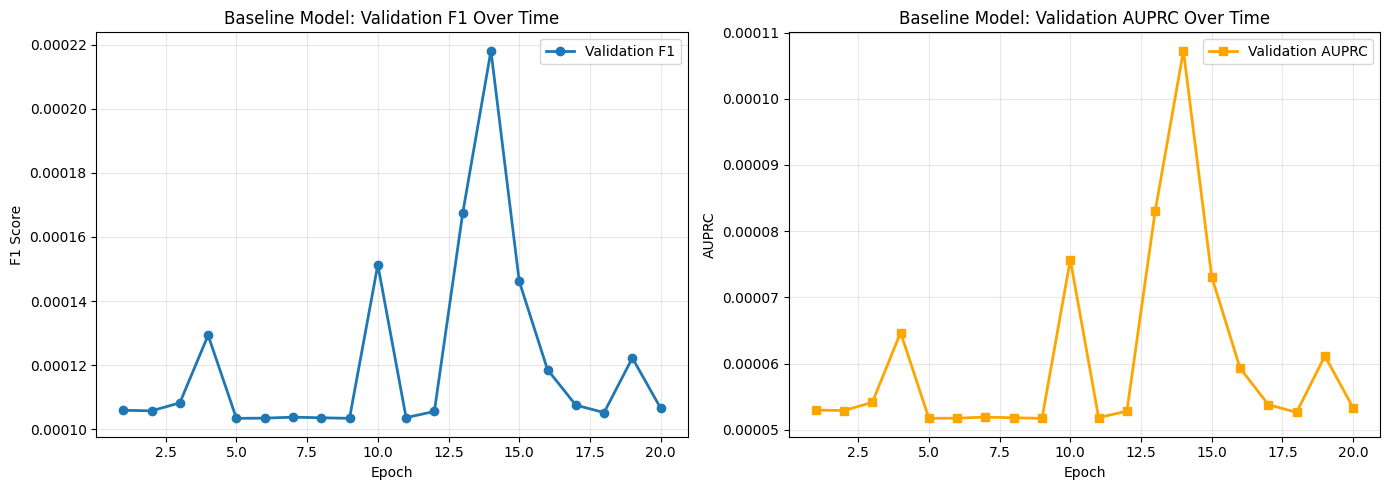


✓ Visualization saved to 'diagnostic_baseline_training.png'


In [11]:
def train_baseline_epoch(model, graphs, optimizer, device):
    """Train baseline on individual graphs (no temporal component)."""
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for graph in graphs:
        graph = graph.to(device)
        
        optimizer.zero_grad()
        out = model(graph.x, graph.edge_index)
        
        # Use class weights in loss
        loss = F.cross_entropy(out, graph.y, weight=class_weights_tensor)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * graph.num_nodes
        pred = out.argmax(dim=1)
        total_correct += (pred == graph.y).sum().item()
        total_samples += graph.num_nodes
    
    return total_loss / total_samples, total_correct / total_samples

def eval_baseline(model, graphs, device):
    """Evaluate baseline model."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for graph in graphs:
            graph = graph.to(device)
            out = model(graph.x, graph.edge_index)
            probs = F.softmax(out, dim=1)
            preds = out.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(graph.y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    preds = np.array(all_preds)
    labels = np.array(all_labels)
    probs = np.array(all_probs)
    
    # Compute metrics
    acc = (preds == labels).mean()
    
    if len(np.unique(labels)) == 2:
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average='binary', pos_label=1, zero_division=0
        )
        try:
            auprc = average_precision_score(labels, probs[:, 1])
            roc_auc = roc_auc_score(labels, probs[:, 1])
        except:
            auprc = 0
            roc_auc = 0
    else:
        precision = recall = f1 = auprc = roc_auc = 0
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auprc': auprc,
        'roc_auc': roc_auc
    }

# Train baseline
print("\nTraining baseline for 20 epochs...")
print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Train Acc':>9} | {'Val F1':>8} | {'Val AUPRC':>10}")
print("-"*60)

baseline_history = {'val_f1': [], 'val_auprc': []}

for epoch in range(1, 21):
    train_loss, train_acc = train_baseline_epoch(baseline_model, train_graphs, baseline_optimizer, DEVICE)
    val_metrics = eval_baseline(baseline_model, val_graphs, DEVICE)
    
    baseline_history['val_f1'].append(val_metrics['f1'])
    baseline_history['val_auprc'].append(val_metrics['auprc'])
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"{epoch:5d} | {train_loss:10.4f} | {train_acc:9.4f} | "
              f"{val_metrics['f1']:8.4f} | {val_metrics['auprc']:10.4f}")

# Final evaluation
test_metrics = eval_baseline(baseline_model, test_graphs, DEVICE)

print("\n" + "="*80)
print(" BASELINE RESULTS")
print("="*80)
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1 Score:  {test_metrics['f1']:.4f}")
print(f"  AUPRC:     {test_metrics['auprc']:.4f}")
print(f"  ROC-AUC:   {test_metrics['roc_auc']:.4f}")

print("\n" + "-"*80)
print(" INTERPRETATION:")
print("-"*80)

if test_metrics['f1'] < 0.05 and test_metrics['auprc'] < 0.05:
    print("❌ BASELINE FAILED: F1 and AUPRC both < 0.05")
    print("\n   This means:")
    print("   - The task is TOO HARD with current features/labels")
    print("   - Even a simple model can't learn anything")
    print("   - Problem is NOT your EvolveGCN architecture")
    print("\n   Root causes:")
    print("   - Features don't correlate with labels")
    print("   - Task is too indirect (predicting neighbors of future transactors)")
    print("   - Labels are too sparse")
    print("\n   Solutions:")
    print("   - Simplify task: predict direct illicit transactions")
    print("   - Engineer better features")
    print("   - Reduce filtering (set ignore_illict=False)")
    
elif test_metrics['f1'] < 0.15:
    print("⚠️  BASELINE WEAK: F1 < 0.15")
    print("\n   The task is VERY DIFFICULT but not impossible")
    print("   - Simple GCN can barely learn")
    print("   - Temporal model (EvolveGCN) might not help much")
    print("\n   Try:")
    print("   - Better features or feature engineering")
    print("   - Adjust label definition")
    print("   - More training data/graphs")
    
else:
    print("✅ BASELINE WORKS: F1 > 0.15")
    print("\n   The task IS LEARNABLE with these features!")
    print("   - If EvolveGCN isn't learning, problem is in temporal setup")
    print("\n   Check:")
    print("   - cumulative=True (graphs should grow over time)")
    print("   - Model architecture (NUM_LAYERS > 0)")
    print("   - Training procedure (temporal sequence handling)")

# Visualize baseline training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = list(range(1, 21))

ax1.plot(epochs, baseline_history['val_f1'], marker='o', linewidth=2, label='Validation F1')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('F1 Score')
ax1.set_title('Baseline Model: Validation F1 Over Time')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(epochs, baseline_history['val_auprc'], marker='s', linewidth=2, label='Validation AUPRC', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUPRC')
ax2.set_title('Baseline Model: Validation AUPRC Over Time')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('diagnostic_baseline_training.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to 'diagnostic_baseline_training.png'")

---

## 📋 COMPREHENSIVE SUMMARY & RECOMMENDATIONS

Based on all diagnostic results above

In [13]:
print("\n" + "="*80)
print(" COMPREHENSIVE DIAGNOSTIC SUMMARY")
print("="*80)

problems_found = []
critical_problems = []
recommendations = []

# Check Diagnostic 1: Graph Structure
if not is_cumulative:
    critical_problems.append("❌ Graphs are NOT cumulative (breaks EvolveGCN)")
    recommendations.append("Set 'cumulative': True in cache_params and rebuild graphs")

# Check Diagnostic 2: Label Distribution
if pos_ratio < 0.1:
    critical_problems.append(f"❌ Extremely sparse labels ({pos_ratio:.3f}% positive)")
    recommendations.append("Set 'ignore_illict': False and 'ignore_previously_transacting_with_illicit': False")
elif pos_ratio < 1.0:
    problems_found.append(f"⚠️  Very sparse labels ({pos_ratio:.3f}% positive)")
    recommendations.append("Use Focal Loss with gamma=2.5-3.0")

# Check Diagnostic 3: Feature Correlation & Combined Power
if len(correlations) > 0:
    if correlations[0][1] < 0.01:
        critical_problems.append(f"❌ Features not predictive (max correlation={correlations[0][1]:.4f})")
        recommendations.append("Consider task simplification or feature engineering")
    elif correlations[0][1] < 0.05:
        problems_found.append(f"⚠️  Weak feature signal (max correlation={correlations[0][1]:.4f})")
        recommendations.append("Feature engineering may help improve performance")

# Check combined predictive power
if 'combined_analysis_results' in locals():
    if combined_analysis_results['lr_f1'] < 0.05:
        critical_problems.append(f"❌ Features have no combined predictive power (LR F1={combined_analysis_results['lr_f1']:.4f})")
        recommendations.append("Features cannot predict labels even when combined - need different features or simpler task")
    elif combined_analysis_results['num_redundant_pairs'] > 10:
        problems_found.append(f"⚠️  High feature redundancy ({combined_analysis_results['num_redundant_pairs']} pairs)")
        recommendations.append("Consider feature selection to remove redundant features")
    
    # Check if graph structure helps (CRITICAL DIAGNOSTIC)
    if 'lr_vs_gcn_analysis' in locals() and test_metrics['f1'] > 0.05 and combined_analysis_results['lr_f1'] > 0.05:
        perf_ratio = lr_vs_gcn_analysis['performance_ratio']
        if perf_ratio < 0.8:
            critical_problems.append(f"❌ Graph HURTS performance! (GCN={test_metrics['f1']:.4f} < LR={combined_analysis_results['lr_f1']:.4f})")
            recommendations.append("URGENT: Graph edges misaligned with task - use feature-only models OR rebuild graphs")
        elif perf_ratio < 1.1:
            problems_found.append(f"⚠️  Graph adds minimal value (GCN F1={test_metrics['f1']:.4f} vs LR F1={combined_analysis_results['lr_f1']:.4f})")
            recommendations.append("Consider simpler feature-based models (LR, XGBoost) instead of GNN")
        
        # Check positive node connectivity
        if lr_vs_gcn_analysis.get('pos_connectivity', 0) < 0.01:
            problems_found.append(f"⚠️  Positive nodes isolated (connectivity={lr_vs_gcn_analysis['pos_connectivity']:.4f})")
            recommendations.append("Positive samples can't share information via message passing")

# Check Diagnostic 4: Baseline Performance
if test_metrics['f1'] < 0.05:
    critical_problems.append(f"❌ Baseline model failed (F1={test_metrics['f1']:.4f})")
    recommendations.append("Task is too hard - simplify prediction target")
elif test_metrics['f1'] < 0.15:
    problems_found.append(f"⚠️  Baseline weak (F1={test_metrics['f1']:.4f})")
    recommendations.append("Task is very difficult - temporal model may not help much")

# Print summary
print("\n" + "="*80)
if critical_problems:
    print("🚨 CRITICAL PROBLEMS FOUND:")
    print("="*80)
    for i, problem in enumerate(critical_problems, 1):
        print(f"\n{i}. {problem}")
    
    print("\n\n" + "="*80)
    print("📋 REQUIRED ACTIONS:")
    print("="*80)
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    print("\n" + "="*80)
    print("⚠️  WARNING: Model will NOT learn until these critical issues are fixed!")
    print("="*80)

elif problems_found:
    print("⚠️  PROBLEMS FOUND (but not critical):")
    print("="*80)
    for i, problem in enumerate(problems_found, 1):
        print(f"\n{i}. {problem}")
    
    print("\n\n" + "="*80)
    print("📋 RECOMMENDED IMPROVEMENTS:")
    print("="*80)
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    print("\n" + "="*80)
    print("Model may learn but will have difficulties. Apply fixes above for better results.")
    print("="*80)

else:
    print("✅ NO MAJOR PROBLEMS DETECTED!")
    print("="*80)
    print("\nYour setup looks reasonable. If model still won't learn:")
    print("  1. Check model architecture (NUM_LAYERS > 0)")
    print("  2. Try lower learning rate (0.0001 - 0.001)")
    print("  3. Train for more epochs (50-100)")
    print("  4. Use Focal Loss for imbalanced data")
    print("  5. Ensure cumulative=True for EvolveGCN")
    print("="*80)

# Summary statistics table
print("\n\n" + "="*80)
print(" DIAGNOSTIC STATISTICS SUMMARY")
print("="*80)

summary_stats = [
    ["Metric", "Value", "Status"],
    ["-"*30, "-"*20, "-"*20],
    ["Graph Structure", "Cumulative" if is_cumulative else "Non-Cumulative", 
     "✅ Good" if is_cumulative else "❌ Bad"],
    ["Positive Label %", f"{pos_ratio:.3f}%", 
     "✅ Good" if pos_ratio >= 1.0 else "⚠️ Sparse" if pos_ratio >= 0.1 else "❌ Very Sparse"],
    ["Max Feature Correlation", f"{correlations[0][1]:.4f}" if correlations else "N/A", 
     "✅ Good" if (correlations and correlations[0][1] >= 0.05) else "⚠️ Weak" if (correlations and correlations[0][1] >= 0.01) else "❌ None"],
    ["Combined Feature Power (LR F1)", f"{combined_analysis_results['lr_f1']:.4f}" if 'combined_analysis_results' in locals() else "N/A",
     "✅ Good" if ('combined_analysis_results' in locals() and combined_analysis_results['lr_f1'] >= 0.15) else "⚠️ Weak" if ('combined_analysis_results' in locals() and combined_analysis_results['lr_f1'] >= 0.05) else "❌ None"],
    ["Feature Redundancy (pairs)", f"{combined_analysis_results['num_redundant_pairs']}" if 'combined_analysis_results' in locals() else "N/A",
     "✅ Low" if ('combined_analysis_results' in locals() and combined_analysis_results['num_redundant_pairs'] < 5) else "⚠️ Moderate" if ('combined_analysis_results' in locals() and combined_analysis_results['num_redundant_pairs'] < 15) else "❌ High"],
    ["Baseline F1 Score", f"{test_metrics['f1']:.4f}", 
     "✅ Good" if test_metrics['f1'] >= 0.15 else "⚠️ Weak" if test_metrics['f1'] >= 0.05 else "❌ Failed"],
    ["Baseline AUPRC", f"{test_metrics['auprc']:.4f}", 
     "✅ Good" if test_metrics['auprc'] >= 0.15 else "⚠️ Weak" if test_metrics['auprc'] >= 0.05 else "❌ Failed"],
    ["Graph vs Feature Ratio", f"{lr_vs_gcn_analysis['performance_ratio']:.2f}x" if 'lr_vs_gcn_analysis' in locals() else "N/A",
     "✅ Graph Helps" if ('lr_vs_gcn_analysis' in locals() and lr_vs_gcn_analysis['performance_ratio'] > 1.1) else "⚠️ Minimal" if ('lr_vs_gcn_analysis' in locals() and lr_vs_gcn_analysis['performance_ratio'] >= 0.8) else "❌ Graph Hurts"],
    ["Positive Node Connectivity", f"{lr_vs_gcn_analysis.get('pos_connectivity', 0):.4f}" if 'lr_vs_gcn_analysis' in locals() else "N/A",
     "✅ Connected" if ('lr_vs_gcn_analysis' in locals() and lr_vs_gcn_analysis.get('pos_connectivity', 0) > 0.05) else "⚠️ Sparse" if ('lr_vs_gcn_analysis' in locals() and lr_vs_gcn_analysis.get('pos_connectivity', 0) > 0.01) else "❌ Isolated"],
]

for row in summary_stats:
    print(f"{row[0]:<30} | {row[1]:<20} | {row[2]:<20}")

print("="*80)

print("\n\n✓ Diagnostic analysis complete!")
print("\nNext steps:")
print("  1. Review the problems found above")
print("  2. Apply the recommended fixes")
print("  3. Rebuild graphs if needed (delete cache first)")
print("  4. Re-run your main training notebook")
print("\nGood luck! 🚀")


 COMPREHENSIVE DIAGNOSTIC SUMMARY

⚠️  PROBLEMS FOUND (but not critical):

1. ⚠️  High feature redundancy (51 pairs)

2. ⚠️  Baseline weak (F1=0.0855)


📋 RECOMMENDED IMPROVEMENTS:
1. Consider feature selection to remove redundant features
2. Task is very difficult - temporal model may not help much

Model may learn but will have difficulties. Apply fixes above for better results.


 DIAGNOSTIC STATISTICS SUMMARY
Metric                         | Value                | Status              
------------------------------ | -------------------- | --------------------
Graph Structure                | Cumulative           | ✅ Good              
Positive Label %               | 5.331%               | ✅ Good              
Max Feature Correlation        | 0.2223               | ✅ Good              
Combined Feature Power (LR F1) | 0.1933               | ✅ Good              
Feature Redundancy (pairs)     | 51                   | ❌ High              
Baseline F1 Score              | 0.0855    